# ЛР6 Кривохата Марія ІМ-21

In [ ]:
import spacy
from spacy.training.example import Example
import random
import json

1. Створити кілька своїх прикладів у форматі json за тематикою варіанту
(англійською або українською мовою) для розпізнавання нового типу
сутностей (обрати самостійно). Створити програму, що додає ці
приклади до існуючої моделі spaCy, навчає модель. Продемонструвати
роботу.

In [19]:
def create_training_example(text, singer_name):
    start = text.find(singer_name)
    if start == -1:
        raise ValueError(f"Singer name '{singer_name}' not found in text!")
    end = start + len(singer_name)
    return (text, {"entities": [(start, end, "SINGER")]})

In [20]:
TRAINING_DATA = [
    create_training_example("Adele will perform in London this July.", "Adele"),
    create_training_example("Next month, 21 Pilots are going to perform in Chicago.", "21 Pilots"),
    create_training_example("I bought tickets for the My Chemical Romance concert.", "My Chemical Romance"),
    create_training_example("At the festival, Queen were headlining the main stage.", "Queen"),
    create_training_example("Many people say that Nirvana's songs still inspire millions.", "Nirvana"),
    create_training_example("The crowd went wild when Paramore appeared on stage.", "Paramore"),
    create_training_example("Few bands had as much influence as The Beatles in the 60s.", "The Beatles"),
    create_training_example("The show will feature performances by Harry Styles and others.", "Harry Styles"),
    create_training_example("After his success on TikTok, Benson Boone released a full album.", "Benson Boone"),
    create_training_example("Emotional lyrics define Mitski, who has a huge fan base.", "Mitski"),
    create_training_example("Fans were amazed by Aurora's voice during her concert.", "Aurora"),
    create_training_example("A tribute to John Lennon will be held in Central Park.", "John Lennon"),
    create_training_example("Taylor Swift is coming to New York for a concert.", "Taylor Swift"),
]


In [21]:
nlp = spacy.load("en_core_web_sm")

if "ner" not in nlp.pipe_names:
    ner = nlp.add_pipe("ner")
else:
    ner = nlp.get_pipe("ner")

ner.add_label("SINGER")

1

In [22]:
examples = []
for text, annotations in TRAINING_DATA:
    doc = nlp.make_doc(text)
    example = Example.from_dict(doc, annotations)
    examples.append(example)


In [24]:
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
with nlp.disable_pipes(*other_pipes):
    optimizer = nlp.create_optimizer()
    for i in range(20):
        random.shuffle(examples)
        for example in examples:
            nlp.update([example], sgd=optimizer)


In [27]:
test_texts = [
    "I can't wait to see Adele live!",
    "Did you hear Taylor Swift is on tour?",
    "Beyoncé will release a new album soon.",
    "I can't believe how amazing 21 Pilots were last night at the stadium!",
    "There was a huge crowd gathered to hear My Chemical Romance live.",
    "We danced all night to the music of Queen under the stars.",
    "Ed Sheeran sings beautifully."
]

for text in test_texts:
    doc = nlp(text)
    print(f"\nText: {text}")
    for ent in doc.ents:
        print(f"Entity: {ent.text}, Label: {ent.label_}")


Text: I can't wait to see Adele live!
Entity: Adele, Label: SINGER

Text: Did you hear Taylor Swift is on tour?
Entity: Taylor Swift, Label: SINGER

Text: Beyoncé will release a new album soon.
Entity: Beyoncé, Label: SINGER

Text: I can't believe how amazing 21 Pilots were last night at the stadium!
Entity: 21 Pilots, Label: SINGER

Text: There was a huge crowd gathered to hear My Chemical Romance live.
Entity: My Chemical Romance, Label: SINGER

Text: We danced all night to the music of Queen under the stars.
Entity: Queen, Label: SINGER

Text: Ed Sheeran sings beautifully.
Entity: Ed Sheeran, Label: SINGER


2. Застосувати компонент TextCategorizer для визначення намірів. Дані для
навчання за тематикою варіанту обрати самостійно або скористатись
вказаним файлом (utterance містить висловлювання, intent - намір). Дані
файли містять приклади діалогів користувачів з системою-помічником за
певною тематикою, наприклад, замовлення квитків і т.д. Навчити
компонент та продемонструвати роботу.

In [125]:
with open("events.json", "r", encoding="utf8") as f:
    data = json.load(f)

In [126]:
training_data = []

for dialogue in data:
    for turn in dialogue.get("turns", []):
        utterance = turn.get("utterance")
        frames = turn.get("frames", [])
        
        for frame in frames:
            intent = frame.get("state", {}).get("active_intent")
            if utterance and intent and intent != "NONE":
                training_data.append((utterance, intent))

print(f"Loaded {len(training_data)} examples")

Loaded 225 examples


In [127]:
from spacy.pipeline.textcat_multilabel import DEFAULT_MULTI_TEXTCAT_MODEL

nlp = spacy.blank("en")

config = {
    "threshold": 0.5,
    "model": DEFAULT_MULTI_TEXTCAT_MODEL
}
textcat = nlp.add_pipe("textcat_multilabel", config=config)

In [128]:
all_intents = set(intent for _, intent in training_data)
for intent in all_intents:
    textcat.add_label(intent)

In [129]:
print(all_intents)

{'GetEventDates', 'BuyEventTickets'}


In [130]:
train_examples = []
for text, label in training_data:
    doc = nlp.make_doc(text)
    example = Example.from_dict(doc, {"cats": {label: 1.0, **{other: 0.0 for other in all_intents if other != label}}})
    train_examples.append(example)


In [134]:
random.shuffle(train_examples)

optimizer = nlp.begin_training()

epochs=50
losses_over_time = []

for epoch in range(epochs):
    losses = {}
    for batch in spacy.util.minibatch(train_examples, size=8):
        nlp.update(batch, drop=0.2, losses=losses)
    losses_over_time.append(losses['textcat_multilabel'])


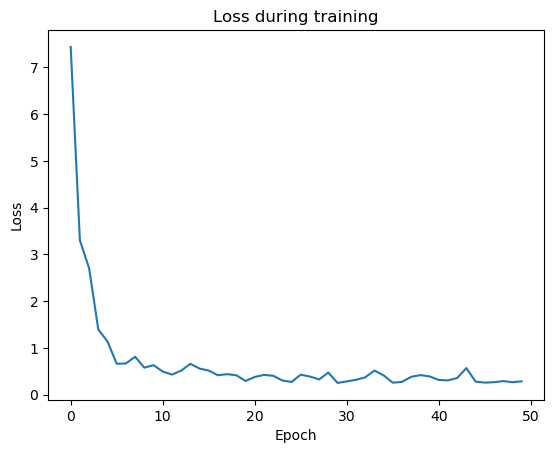

In [135]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), losses_over_time)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss during training')
plt.show()

In [136]:
test_texts = [
    "Are there other dates listed for the events?",
    "When is the next football match in London?",
    "Can you tell me the schedule for the next basketball game?",
    "I'd like to know the dates for the upcoming tennis tournament in Paris.",
    "When does the marathon take place this year?",
    "What day is the next rugby match in New York?",
    "When is the concert for Taylor Swift happening in Los Angeles?",

    "Book me a ticket for the concert in New York.",
    "I want to purchase tickets for the event in Paris.",
    "Can you help me buy tickets for the theater play?",
    "How can I buy tickets for the basketball match in Boston?"
]

for text in test_texts:
    doc = nlp(text)
    scores = doc.cats
    predicted_intent = max(scores, key=scores.get)
    print(f"Text: {text}")
    print(f"Predicted intent: {predicted_intent} (score: {scores[predicted_intent]:.2f})")
    print("-" * 50)


Text: Are there other dates listed for the events?
Predicted intent: GetEventDates (score: 1.00)
--------------------------------------------------
Text: When is the next football match in London?
Predicted intent: GetEventDates (score: 1.00)
--------------------------------------------------
Text: Can you tell me the schedule for the next basketball game?
Predicted intent: GetEventDates (score: 0.65)
--------------------------------------------------
Text: I'd like to know the dates for the upcoming tennis tournament in Paris.
Predicted intent: GetEventDates (score: 1.00)
--------------------------------------------------
Text: When does the marathon take place this year?
Predicted intent: GetEventDates (score: 1.00)
--------------------------------------------------
Text: What day is the next rugby match in New York?
Predicted intent: GetEventDates (score: 1.00)
--------------------------------------------------
Text: When is the concert for Taylor Swift happening in Los Angeles?
Pre